In [2]:
from tempForecast.components.data_transformation import WeatherDatabase
from tempForecast.components.data_ingestion import weather_scraping

In [3]:
data = weather_scraping().load_data()
# on instancie la classe avec la base de donnée déjà chargé pour ne pas rescrapé tout
# si on met last_df en argument cela va scrapper seulement depuis la dernière date du df donc enlever pour éviter une interpolation
data_ingestion = weather_scraping(last_df=data)
# scraping 

data = data_ingestion.web_scraping()
# il faut ajouter cette base à la db
data_ingestion.load_data(df=data)
data = WeatherDatabase().load_data_and_transform()

2023-11-27 19:03:21.026639
https://www.infoclimat.fr/observations-meteo/archives/27/novembre/2023/paris-5eme-tour-zamansky-jussieu/000BV.html?dixminutes


In [4]:
#data["unique_id"] = "temp"
data.rename(columns={"température":"y"}, inplace=True)
#data.rename(columns={"datetime":"ds"}, inplace=True)

data['y'].fillna(method='bfill', inplace=True)
data['vent'].fillna(method='bfill', inplace=True)
data['rafales'].fillna(0, inplace=True)
data['vent_direction'].fillna(0, inplace=True)
data['pt_de_rosee'].fillna(0, inplace=True)
data['humidite'].fillna(0, inplace=True)


In [5]:
data.drop(columns=['bio_meteo','radiation_solaire'], inplace=True)
data.drop(columns='id', inplace=True)

In [6]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS


In [10]:
data.rename(columns={"datetime":"ds"}, inplace=True)

In [17]:
data['unique_id'] = 'temp'

Seed set to 1
Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.24it/s]


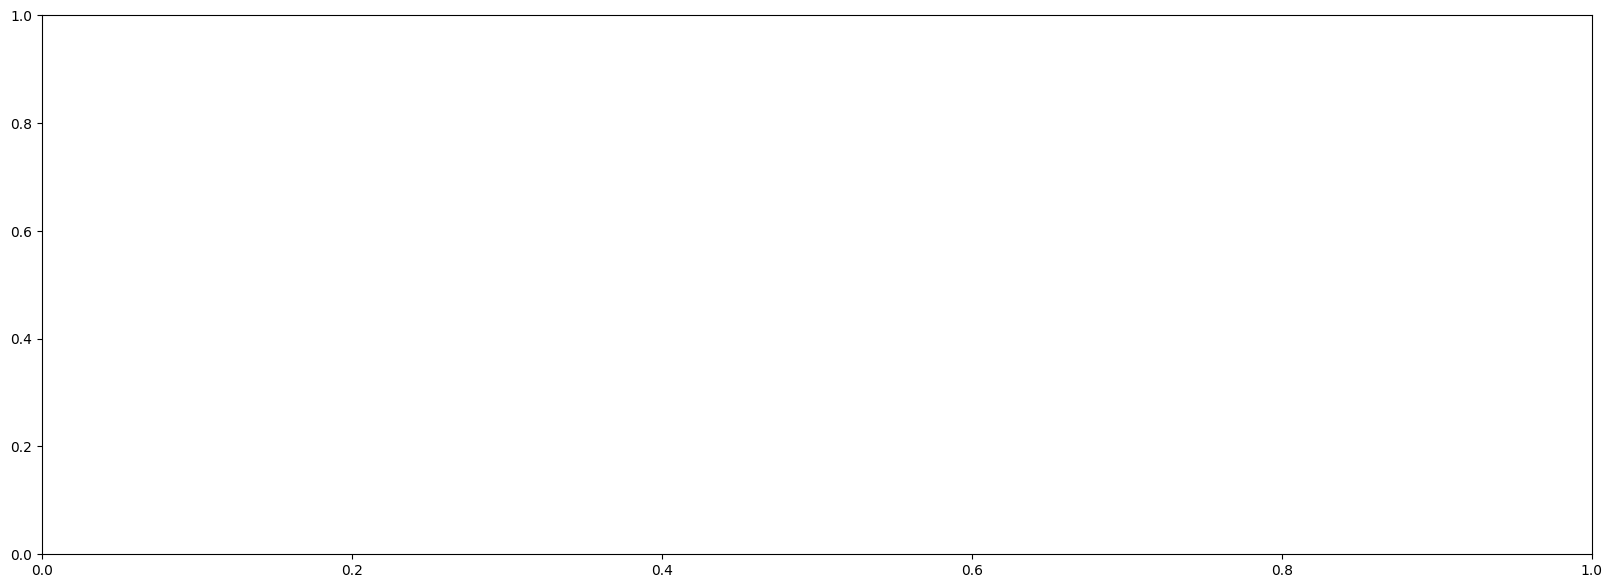

In [35]:
Y_train_df = data[:-144]# 132 train
Y_test_df = data[-144:] # 12 test

# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
          NHITS(input_size=2 * horizon, h=horizon, max_steps=50)]
nf = NeuralForecast(models=models, freq='10T')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

In [36]:
predict = nf.predict()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.44it/s]


In [37]:
predict

,ds,NBEATS,NHITS
unique_id,,,
temp,2023-11-26 10:30:00,4.837996,4.830884
temp,2023-11-26 10:40:00,4.864153,4.931422
temp,2023-11-26 10:50:00,4.911466,4.988553
temp,2023-11-26 11:00:00,4.920751,5.012304
temp,2023-11-26 11:10:00,5.180236,5.087783
...,...,...,...
temp,2023-11-27 09:40:00,5.043230,4.628317
temp,2023-11-27 09:50:00,4.669049,4.826194
temp,2023-11-27 10:00:00,4.558552,4.943285


In [38]:
predict.index = predict.ds

In [39]:
predict = predict.drop(columns="ds")

In [40]:
predict.columns

Index(['NBEATS', 'NHITS'], dtype='object')

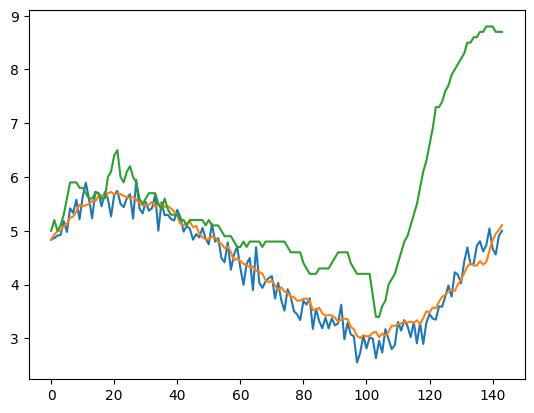

In [41]:
plt.plot(predict[['NBEATS','NHITS']].values)
plt.plot(Y_test_df['y'].values)

In [43]:
from neuralforecast.losses.numpy import mae


In [45]:
mae_informer = mae(Y_hat_df['y'], Y_hat_df['NBEATS'])
mae_autoformer = mae(Y_hat_df['y'], Y_hat_df['NHITS'])

print(f'Informer: {mae_informer:.3f}')
print(f'Autoformer: {mae_autoformer:.3f}')


Informer: 0.553
Autoformer: 0.475
